# Travistorrent Analysis

* Data source: https://travistorrent.testroots.org/dumps/travistorrent_8_2_2017.csv.gz
* Data format: https://travistorrent.testroots.org/page_dataformat/


Beller M, Gousios G, Zaidman A. (2017) TravisTorrent: Synthesizing Travis CI and GitHub for Full-Stack Research on Continuous Integration

@inproceedings{msr17challenge,
 title={TravisTorrent: Synthesizing Travis CI and GitHub for Full-Stack Research on Continuous Integration},
 author={Beller, Moritz and Gousios, Georgios and Zaidman, Andy},
 booktitle={Proceedings of the 14th working conference on mining software repositories},
 preprint={http://www.st.ewi.tudelft.nl/~mbeller/publications/2017_beller_gousios_zaidman_travistorrent_synthesizing_travis_ci_and_github_for_full-stack_research_on_continuous_integration.pdf},
 year={2017}
}

In [80]:
install.packages('data.table')

## needed for gzip
install.packages('R.utils') 

Installing package into ‘/usr/local/spark-2.3.1-bin-hadoop2.7/R/lib’
(as ‘lib’ is unspecified)
Installing package into ‘/usr/local/spark-2.3.1-bin-hadoop2.7/R/lib’
(as ‘lib’ is unspecified)
also installing the dependencies ‘R.oo’, ‘R.methodsS3’



In [81]:
require('data.table')

## needed for direct file download
 require('R.utils')
 download.file("https://travistorrent.testroots.org/dumps/travistorrent_8_2_2017.csv.gz", "travistorrent_8_2_2017.csv.gz")
 gunzip("travistorrent_8_2_2017.csv.gz", remove=FALSE)

tt <- fread("travistorrent_8_2_2017.csv")

Loading required package: R.utils
Loading required package: R.oo
Loading required package: R.methodsS3
R.methodsS3 v1.7.1 (2016-02-15) successfully loaded. See ?R.methodsS3 for help.
R.oo v1.22.0 (2018-04-21) successfully loaded. See ?R.oo for help.

Attaching package: ‘R.oo’

The following objects are masked from ‘package:methods’:

    getClasses, getMethods

The following objects are masked from ‘package:base’:

    attach, detach, gc, load, save

R.utils v2.6.0 (2017-11-04) successfully loaded. See ?R.utils for help.

Attaching package: ‘R.utils’

The following object is masked from ‘package:utils’:

    timestamp

The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, inherits, isOpen, parse, warnings



ERROR: Error in decompressFile.default(filename = filename, ..., ext = ext, FUN = FUN): File already exists: travistorrent_8_2_2017.csv


We select the interesting columns and remove duplicate build_ids as they are duplicates for sub_jobs. In addition, we remove all entries that do not have a duration.


In [82]:
tt <- tt[tt$tr_duration != "NA"]
tt <- tt[, c("tr_build_id","git_branch","gh_project_name","gh_build_started_at","tr_duration")]
tt <- tt[!duplicated(tt$tr_build_id),]

In [83]:
# Assign start and duration to variables
tt_start <- tt$gh_build_started_at
tt_duration<- tt$tr_duration

# Extract epoch formats for start and end by adding duration to start
tt_start_epoch <- as.POSIXct(tt_start ,format="%Y-%m-%d %H:%M")
tt_end_epoch <- tt_start_epoch + tt_duration
#tt_end_epoch <- as.POSIXct(as.POSIXlt(tt_end_epoch), format="%Y-%m-%d %H:%M")
tt_end_epoch <- strptime(tt_end_epoch, "%Y-%m-%d %H:%M")

# Find min and max time
time_min <- min(tt_start_epoch)
time_max <- max(tt_end_epoch)

Luckily found a good example on how to aggregate: https://stackoverflow.com/a/20426276/1779346

In [84]:
options(digits.secs=0)

In [85]:
queries.start <- data.frame(Time=tt_start_epoch, Value=1)
queries.end <- data.frame(Time=tt_end_epoch, Value=-1)

queries.both <- rbind(queries.start, queries.end)
queries.both <- queries.both[with(queries.both, order(Time)), ]

queries.sum <- data.frame(Time=queries.both$Time, Queries=cumsum(queries.both$Value))

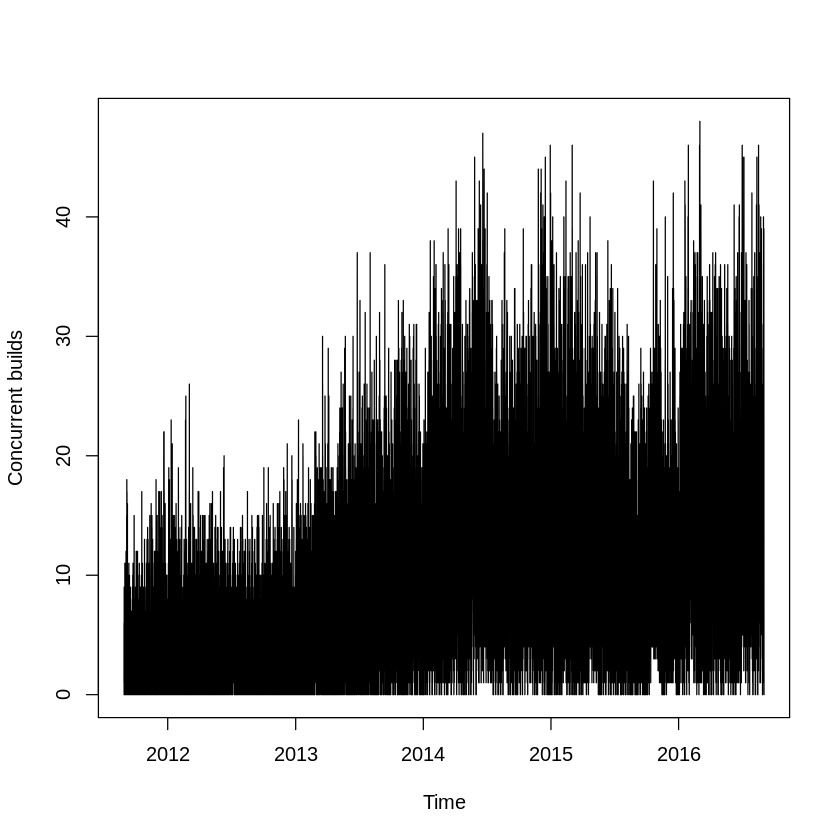

In [86]:
plot(queries.sum, type="l", ylab="Concurrent builds")

In [87]:
saveRDS(queries.sum, file="dataset.Rda")